In [93]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import scipy.stats
import pickle
import sys
outdir = "../../../../../data/FED/plots/01_enformer_benchmark"

## Identify tracks that are comarable btw human and mouse

In [2]:
filepath =  "/home/luisasantus/Desktop/crg_cluster/data/FED/suppl_df.pkl"
with open(filepath, 'rb') as file:
    suppl_df = pickle.load(file) 

In [3]:
# extract tracks 
suppl_df_cage = suppl_df.loc[suppl_df['assay_type'] == "CAGE"]
cerebellum_targets = suppl_df_cage[suppl_df_cage["biosource"] == "cerebellum"][list(["target", "organism"])]
train_tracks_ind =  cerebellum_targets[cerebellum_targets.organism == "human"].index
pred_tracks_ind =  cerebellum_targets[cerebellum_targets.organism == "mouse"].index

In [154]:
# save tracks for running
biosource = "cerebellum"
output_dir = "/home/luisasantus/Desktop/crg_cluster/data/FED/enformer/human/mouse/pred_standard"
train_csv = os.path.join(output_dir, biosource, "train_tracks.csv")
pred_csv = os.path.join(output_dir, biosource, "pred_tracks.csv")
pd.DataFrame(train_tracks_ind).to_csv(train_csv, index=False)
pd.DataFrame(pred_tracks_ind).to_csv(pred_csv, index=False)

In [ ]:
# ---------- RUN ON CLUSTER ------------------

In [331]:
head_train = "human"
head_pred = "mouse"
biosource = "cerebellum"

In [450]:
def get_evaluation_summary(head_train, head_pred, biosource):
    suppl_df_train = suppl_df[suppl_df.organism == head_train]
    suppl_df_pred = suppl_df[suppl_df.organism == head_pred]
    
    output_dir = "/home/luisasantus/Desktop/crg_cluster/data/FED/enformer/"+head_train+"/"+head_pred+"/pred_standard"

    
    path = os.path.join(output_dir, biosource, "correlation_evaluation.csv")
    evaluation_df = pd.read_csv(path)  
    evaluation_df = evaluation_df[evaluation_df.targets!="targets"]
    evaluation_df.pearson = list(map(float, evaluation_df.pearson))
    # Extract list of indeces and add description 
    list_of_indexes = list(map(int,list(evaluation_df["targets"])))
    list_of_indexes_pred = list(map(int,list(evaluation_df["preds"])))
    evaluation_df["description_target"] = list(suppl_df_train.iloc[list_of_indexes, :].description)
    evaluation_df["description_pred"] = list(suppl_df_pred.iloc[list_of_indexes_pred, :].description)
    evaluation_df["target_subset"] = evaluation_df.description_target.str.split(",", n = 0, expand = True)[1]
    evaluation_df["pred_subset"] = evaluation_df.description_pred.str.split(",", n = 0, expand = True)[1]
    return(evaluation_df)

def get_matrix_for_hm(evaluation_df):
    df_matrix = evaluation_df.groupby(list(["target_subset","pred_subset"])).mean("pearson").reset_index()
    df_matrix = df_matrix.pivot(index='target_subset', columns='pred_subset', values='pearson')
    return(df_matrix)

In [449]:
evaluation_df_h_m = get_evaluation_summary("human", "mouse", "cerebellum")

# prep 
evaluation_df_h_m.pred_subset = ["embryo" if "embryo" in ele else ele for ele in list(evaluation_df_h_m["pred_subset"])]
evaluation_df_h_m.pred_subset = ["newborn" if "neonate" in ele else ele for ele in list(evaluation_df_h_m["pred_subset"])]


In [451]:
df_matrix_h_m = get_matrix_for_hm(evaluation_df_h_m)

In [470]:
df_matrix_h_m

pred_subset,adult,embryo,newborn
target_subset,,,
adult,0.44529,0.440618,0.434598
newborn,0.37587,0.381705,0.373121


# Visualize

### Human model predicts on mouse 

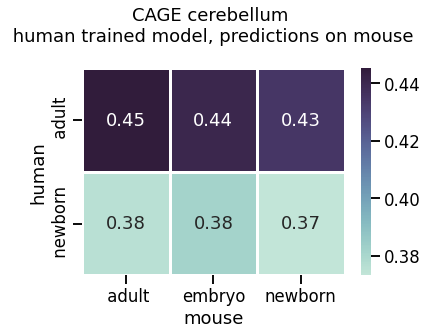

In [498]:
head_train = "human"
head_pred = "mouse"
sns.set_context("talk")
fig, axes = plt.subplots(figsize=(6,5))
pal = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

s = sns.heatmap(df_matrix_h_m, annot=True, linewidth=3, linecolor='w', cmap = pal)

s.set(xlabel= head_pred,
      ylabel= head_train,
      title = "CAGE cerebellum \n human trained model, predictions on mouse \n")

fig.tight_layout()
plt.savefig(os.path.join(outdir, "02_cross_CAGEcerebellum_human_mouse.pdf"))


### Mouse model predicts on human 

In [462]:
evaluation_df_m_h = get_evaluation_summary("mouse", "human", "cerebellum")
# prep 
evaluation_df_m_h.target_subset = ["embryo" if "embryo" in ele else ele for ele in list(evaluation_df_m_h["target_subset"])]
evaluation_df_m_h.target_subset = ["newborn" if "neonate" in ele else ele for ele in list(evaluation_df_m_h["target_subset"])]
df_matrix_m_h = get_matrix_for_hm(evaluation_df_m_h)
df_matrix_m_h

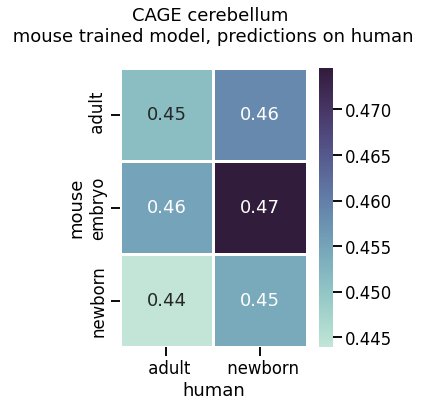

In [499]:
head_train = "mouse"
head_pred = "human"
sns.set_context("talk")
fig, axes = plt.subplots(figsize=(5,6))
pal = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)


s = sns.heatmap(df_matrix_m_h, annot=True, linewidth=3, linecolor='w', cmap=pal)

s.set(xlabel= head_pred,
      ylabel= head_train,
      title = "CAGE cerebellum \n mouse trained model, predictions on human \n")

fig.tight_layout()
plt.savefig(os.path.join(outdir, "02_cross_CAGEcerebellum_mouse_human.pdf"))
